<a href="https://colab.research.google.com/github/thdefn/jango/blob/master/trs_150.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization 
from tensorflow.keras.utils import to_categorical

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

import seaborn as sns
import os
import glob
import plotly.graph_objects as go
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tqdm import tqdm

In [ ]:
root_dir = '../input/intel-mobileodt-cervical-cancer-screening'
train_dir = os.path.join(root_dir,'train', 'train')

type1_dir = os.path.join(train_dir, 'Type_1')
type2_dir = os.path.join(train_dir, 'Type_2')
type3_dir = os.path.join(train_dir, 'Type_3')

train_type1_files = glob.glob(type1_dir+'/*.jpg')
train_type2_files = glob.glob(type2_dir+'/*.jpg')
train_type3_files = glob.glob(type3_dir+'/*.jpg')


added_type1_files  =  glob.glob(os.path.join(root_dir, "additional_Type_1_v2", "Type_1")+'/*.jpg')
added_type2_files  =  glob.glob(os.path.join(root_dir, "additional_Type_2_v2", "Type_2")+'/*.jpg')
added_type3_files  =  glob.glob(os.path.join(root_dir, "additional_Type_3_v2", "Type_3")+'/*.jpg')


type1_files = train_type1_files + added_type1_files
type2_files = train_type2_files + added_type2_files
type3_files = train_type3_files + added_type3_files

print(f'''Type 1 files for training: {len(type1_files)} 
Type 2 files for training: {len(type2_files)}
Type 3 files for training: {len(type3_files)}''' )

Type 1 files for training: 1441 
Type 2 files for training: 4348
Type 3 files for training: 2426


In [ ]:
files = {'filepath': type1_files + type2_files + type3_files,
          'label': ['Type 1']* len(type1_files) + ['Type 2']* len(type2_files) + ['Type 3']* len(type3_files)}

files_df = pd.DataFrame(files).sample(frac=1, random_state= 1).reset_index(drop=True)
files_df

,filepath,label
0,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
1,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
2,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
3,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
4,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
...,...,...
8210,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
8211,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
8212,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
8213,../input/intel-mobileodt-cervical-cancer-scree...,Type 2


In [ ]:
bad_files = []
for path in tqdm(files_df['filepath'].values):
    try:
        img = Image.open(path)
    except:
        index = files_df[files_df['filepath']==path].index.values[0]
        bad_files.append(index)

100%|██████████| 8215/8215 [01:57<00:00, 69.74it/s]


In [ ]:
bad_files
files_df.drop(bad_files, inplace=True)
files_df

,filepath,label
0,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
1,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
2,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
3,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
4,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
...,...,...
8210,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
8211,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
8212,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
8213,../input/intel-mobileodt-cervical-cancer-scree...,Type 2


In [ ]:
#train_df, valid_df = train_test_split(files_df, test_size = 0.2, stratify = files_df['label'], random_state = 1234)
k = ImageDataGenerator(rescale=1./ 255, validation_split=0.2)
t_nongen = k.flow_from_dataframe(files_df, x_col='filepath', y_col='label', target_size = (150, 150), class_mode='categorical', color_mode='rgb', subset='training')
v_nongen = k.flow_from_dataframe(files_df, x_col='filepath', y_col='label', target_size = (150, 150), class_mode='categorical', color_mode='rgb', subset='validation')

Found 6570 validated image filenames belonging to 3 classes.
Found 1642 validated image filenames belonging to 3 classes.


In [ ]:
# 사전 교육된 기본 모델 가져오기
base_model = VGG19(include_top=False, weights='imagenet',input_shape=(150, 150, 3))

base_model.trainable = False

# 교육할 계층 설정 최상위 계층만 교육하기 위해 (False 가중치 고정)
for layer in base_model.layers:
    layer.trainable = False
    
# 기본 모델의 마지막 층
x = base_model.output

x = Flatten()(x)
h1 = Dense(512, activation='relu')(x)
drop1 = Dropout(rate=0.5)(h1)
h2 = Dense(512, activation='relu')(drop1)
drop2 = Dropout(rate=0.5)(h2)
output = Dense(3, activation='softmax')(drop2)

trs = Model(inputs=base_model.input, outputs=output)
trs.summary()

2022-11-21 21:53:31.142282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 21:53:31.143369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 21:53:31.320560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 21:53:31.321530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 21:53:31.322423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

80150528/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:
trs.compile(optimizer=RMSprop(lr=1e-4),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [ ]:
general = trs.fit(t_nongen, validation_data= v_nongen, epochs= 20, verbose=1)

2022-11-21 21:53:44.475206: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-11-21 21:53:54.642272: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


206/206 [==============================] - 2089s 10s/step - loss: 1.0789 - accuracy: 0.4811 - val_loss: 0.9702 - val_accuracy: 0.5286
Epoch 2/20
206/206 [==============================] - 2060s 10s/step - loss: 0.9876 - accuracy: 0.5181 - val_loss: 0.9560 - val_accuracy: 0.5238
Epoch 3/20
206/206 [==============================] - 2052s 10s/step - loss: 0.9716 - accuracy: 0.5262 - val_loss: 0.9366 - val_accuracy: 0.5323
Epoch 4/20
206/206 [==============================] - 2112s 10s/step - loss: 0.9486 - accuracy: 0.5449 - val_loss: 0.9411 - val_accuracy: 0.5359
Epoch 5/20
206/206 [==============================] - 2112s 10s/step - loss: 0.9266 - accuracy: 0.5521 - val_loss: 0.9326 - val_accuracy: 0.5420
Epoch 6/20
206/206 [==============================] - 2062s 10s/step - loss: 0.9160 - accuracy: 0.5597 - val_loss: 0.9102 - val_accuracy: 0.5627
Epoch 7/20
206/206 [==============================] - 2000s 10s/step - loss: 0.8822 - accuracy: 0.5817 - val_loss: 0.9007 - val_accuracy: 0.5

In [2]:

history = {'loss':     [1.0789,0.9876,0.9716,0.9486,0.9266,0.9160,0.8822,0.8682,0.8561,0.8365,0.8178,0.7980,0.7753,0.7646,0.7365,0.7165,0.6955,0.6711,0.6474,0.6325],
 'accuracy': [0.4811,0.5181,0.5262,0.5449,0.5521,0.5597,0.5817,0.5831,0.5921,0.6068,0.6125,0.6306,0.6479,0.6521,0.6686,0.6849,0.6977,0.7027,0.7177,0.7277],
 'val_loss': [0.9702,0.9560,0.9366,0.9411,0.9326,0.9102,0.9007,0.8951,0.8747,0.8826,0.8652,0.8493,0.8574,0.8583,0.8355,0.8853,0.8411,0.8409,0.8515,0.8714],
 'val_accuracy': [0.5286,0.5238,0.5323,0.5359,0.5420,0.5627,0.5609,0.5554,0.5792,0.5566,0.5895,0.5950,0.5950,0.6023,0.6157,0.6023,0.6090,0.6364,0.6303,0.6236]}


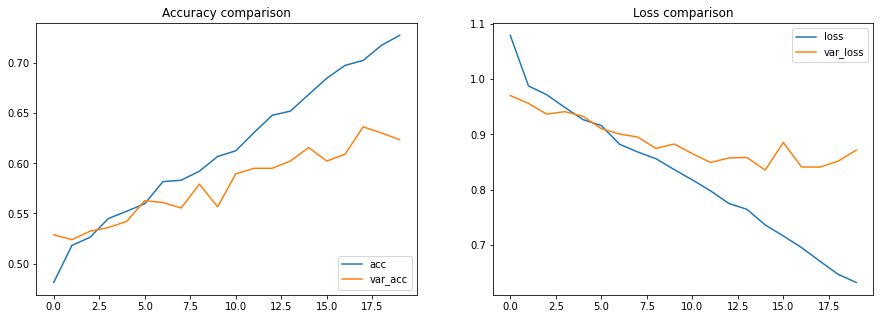

In [6]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='acc')
plt.plot(history['val_accuracy'], label='var_acc')
plt.legend(loc='lower right')
plt.title('Accuracy comparison')

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='var_loss')
plt.legend(loc='upper right')
plt.title('Loss comparison')

plt.show()